In [1]:
# Colab was used for this notebook hence the library installs
%%capture
!pip install pycaret --quiet --upgrade
!pip install dabl --quiet --upgrade
!pip install shap --quiet --upgrade
!pip install sdv  --quiet --upgrade
!pip install sdv[ctgan] --quiet --upgrade
!pip install baytune --quiet --upgrade
!pip install optuna --quiet --upgrade

UsageError: Line magic function `%%capture` not found.


## **Why this was done**
1. Learn about synthetic data generation and see if it can improve a model
2. Work with PyCaret on a classification problem
3. Work on an insurance related problem (although ficticious data)
4. Build a `streamlit` app

## **The data**
HR data isn't easy to find given the nature of the data. However IBM has created [fictious data](https://www.kaggle.com/pavansubhasht/ibm-hr-analytics-attrition-dataset) around whether an employee left after 6 months which can be used. The features for each employee are...

* ` age `
* ` bmi `
* ` children `
* ` sex `
* ` smoker `
* ` region `


# **Libraries**

In [2]:
from pycaret.classification import * 
#from pycaret.regression import * # Preprocessing, modelling, interpretation, deployment...
from sklearn.impute import SimpleImputer
import pandas as pd # Basic data manipulation
#import dabl as db # Summary plot
from sklearn.model_selection import train_test_split # Data split
from sdv.tabular import CopulaGAN, GaussianCopula, CTGAN # Synthetic data
from sdv.evaluation import evaluate # Evaluate synthetic data
#from btb.tuning import Tunable, GCPTuner # CopulaGAN optimising
#from btb.tuning import hyperparams as hp  # Set hyperparameters for optimising
import joblib # Saving preparation steps
import sdv.constraints as cons # Evaluate synthetic data

# **Importing data**

In [3]:
# Read and output the top 5 rows
ins_data = pd.read_csv("insurance.csv")
ins_data

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520
...,...,...,...,...,...,...,...
1333,50,male,30.970,3,no,northwest,10600.54830
1334,18,female,31.920,0,no,northeast,2205.98080
1335,18,female,36.850,0,no,southeast,1629.83350
1336,21,female,25.800,0,no,southwest,2007.94500


156


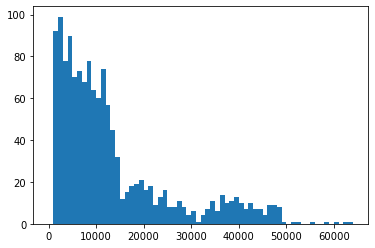

In [4]:
ins_data = pd.read_csv("insurance.csv")
from matplotlib import pyplot as plt
plt.hist(ins_data['charges'], bins=[1000*i for i in range (65)])
ins_data['charges'].describe()
def transform(x):
    if x<5000: return 0 # First"Peak"
    if x<16000: return 1 # Second Peak
    if x<31000: return 2 # Thrid Peak
    return 3
print(len(ins_data[ins_data["charges"]>31000]))
ins_data["charges"]=ins_data["charges"].map(transform)

A fairly simply ordering per feature. 


Now feature(s) can be initialised
* Target feature
* Continuous features
* Ordinal features
* Categorical features
* Features to ignore

In [5]:
# Target feature
target = "charges"

# Continuous/numeric features
cont_feats = ["age", "bmi"]

# Ordinal features
ord_feats = {"children" : ["0", "1", "2", "3", "4", "5"]}

# Categorical geatures
cat_feats = ["region", "smoker", "sex"]

# There is a value error for children:
# ValueError: The least populated class in y has only 1 member, which is too few. The minimum number of groups for any class cannot be less than.


The ratio of the original data of charge >14000 is 0.0000


(array([359., 633., 190., 156.]),
 array([0, 1, 2, 3, 4]),
 <a list of 4 Patch objects>)

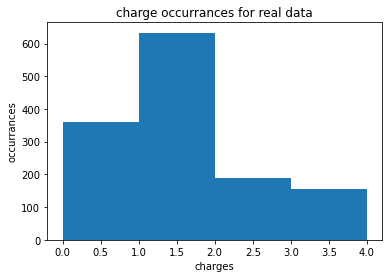

In [6]:
total02=len(ins_data["charges"])
ans02 = []
for i in range(4):
    num=len(ins_data["charges"][ins_data["charges"]==i])
    ans02.append(num/total02)
ans02=np.array(ans02)
print("The ratio of the original data of charge >14000 is %.4f"%sum(ans02[14:]))
plt.title("charge occurrances for real data")
plt.xlabel("charges")
plt.ylabel("occurrances")
plt.hist(ins_data["charges"],bins=[i for i in range (5)])

In [7]:
# Split real data into training + test set
train, test, target_train, target_test = train_test_split(ins_data.drop("charges", axis = 1), ins_data["charges"], test_size = 0.4, random_state = 42)

# Add Attrition column back into training + test set
train["charges"] = target_train
test["charges"] = target_test

The ratio of the original TRAIN data of charge >14000 is 0.0000


(array([211., 380., 122.,  89.]),
 array([0, 1, 2, 3, 4]),
 <a list of 4 Patch objects>)

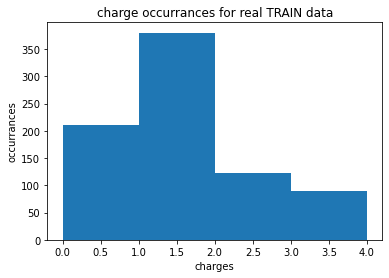

In [8]:
total02=len(train["charges"])
ans02 = []
for i in range(4):
    num=len(train["charges"][train["charges"]==i])
    ans02.append(num/total02)
ans02=np.array(ans02)
print("The ratio of the original TRAIN data of charge >14000 is %.4f"%sum(ans02[14:]))
plt.title("charge occurrances for real TRAIN data")
plt.xlabel("charges")
plt.ylabel("occurrances")
plt.hist(train["charges"],bins=[i for i in range (5)])

In [9]:
# Run pycaret setup
setup(data = train, 
      target = target, 
      test_data = test,
      numeric_features = cont_feats,
      categorical_features = cat_feats,
      ordinal_features = ord_feats,
      normalize_method = "zscore",
      ignore_low_variance = True,
      silent = True,
      verbose = False)

(25      1
 336     1
 47      0
 106     0
 1269    1
        ..
 1095    0
 1130    1
 1294    1
 860     3
 1126    1
 Name: charges, Length: 802, dtype: int32,
        age        bmi  children  sex_female  smoker_no  region_northeast  \
 764   45.0  25.174999       2.0         1.0        1.0               1.0   
 887   36.0  30.020000       0.0         1.0        1.0               0.0   
 890   64.0  26.885000       0.0         1.0        0.0               0.0   
 1293  46.0  25.745001       3.0         0.0        1.0               0.0   
 259   19.0  31.920000       0.0         0.0        0.0               0.0   
 ...    ...        ...       ...         ...        ...               ...   
 588   61.0  35.910000       0.0         1.0        1.0               1.0   
 872   42.0  24.860001       0.0         0.0        1.0               0.0   
 914   33.0  24.605000       2.0         0.0        1.0               0.0   
 679   49.0  23.180000       2.0         1.0        1.0           

Now it's "setup", I like to use `compare_models` to get a rough idea as to which model(s) might be best for this particular use case. The particular metrics I'm looking at are `AUC`, `Precision` and `Recall`. `Recall` is most important as we want to make sure we are correctly identifying the **true negatives** i.e. those that might leave in 6 months. Cross validation is also used.

In [10]:
compare_models()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
rf,Random Forest Classifier,0.8766,0.9338,0.8431,0.8784,0.8714,0.8136,0.8169,0.1850
gbc,Gradient Boosting Classifier,0.8715,0.9340,0.8354,0.8734,0.8660,0.8054,0.8089,0.1550
lr,Logistic Regression,0.8641,0.9184,0.8133,0.8678,0.8563,0.7924,0.7979,0.9230
lightgbm,Light Gradient Boosting Machine,0.8641,0.9339,0.8289,0.8659,0.8587,0.7950,0.7982,0.0930
ridge,Ridge Classifier,0.8504,0.0000,0.7909,0.8600,0.8322,0.7723,0.7804,0.0170
et,Extra Trees Classifier,0.8503,0.9298,0.8131,0.8523,0.8482,0.7747,0.7772,0.1400
lda,Linear Discriminant Analysis,0.8392,0.9222,0.7714,0.8444,0.8131,0.7560,0.7664,0.0200
dt,Decision Tree Classifier,0.8154,0.8666,0.8002,0.8263,0.8163,0.7268,0.7297,0.0220
ada,Ada Boost Classifier,0.7619,0.8576,0.6504,0.6943,0.7176,0.6379,0.6526,0.0870
nb,Naive Bayes,0.7443,0.9201,0.7422,0.7894,0.7368,0.6294,0.6525,0.0260


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=1791, verbose=0,
                       warm_start=False)

So `Logistic Regression` is looking promising for `AUC` but `Recall` is not high, regardless I'll build a model on this. As shown below each fold's metrics are shown and the average from them.

In [11]:
rf = create_model("rf") # Create logistic regression model

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.9136,0.9784,0.9033,0.9111,0.9110,0.8706,0.8714
1,0.8395,0.9269,0.8320,0.8395,0.8393,0.7630,0.7632
2,0.8500,0.9222,0.8106,0.8387,0.8405,0.7725,0.7749
3,0.9000,0.9346,0.8638,0.9030,0.8977,0.8470,0.8500
4,0.9000,0.9286,0.8549,0.8997,0.8956,0.8494,0.8521
5,0.8625,0.9413,0.8334,0.8678,0.8617,0.7892,0.7928
6,0.8375,0.8769,0.7935,0.8308,0.8280,0.7548,0.7587
7,0.9250,0.9755,0.8912,0.9255,0.9234,0.8864,0.8876
8,0.8750,0.9395,0.8348,0.8853,0.8737,0.8132,0.8178
9,0.8625,0.9145,0.8136,0.8823,0.8435,0.7897,0.8002


Some hyperparameter tuning may help improve the model a bit so I'll use `tune_model` and focus on `AUC`. I'm using the `optuna` library and searching using `tpe` searching algorithm.

Overall there doesn't seem like much improvement.

# **Generating synthetic data** 
# **NAIVE GENERATING**
# **GAUSSIANCOPULA**
There's a useful library `sdev` [Synthetic Data Generation](https://github.com/sdv-dev/SDV) to generate synthetic tabular data. I've played around with it specifically the `CopulaGAN` model.

The general idea is to provide a `primary key` and to then run the model for so many `epochs`. There are hyperparameters to tune
* `epochs`
* `batch_size`
* `embedding_dim`
* `gen_dim`
* `dis_dim`
* `l2scale` (omitted in this experiment)



Rather than running a CopulaGAN without hyperparameters or guessing hyperparameters I've leveraged `BTB` [Bayesian Tuning and Bandits](https://github.com/MLBazaar/BTB) which is an optimisation library. To start I'll initialise the `GCPTuner` which is used to declare the hyperparameters to tune. Then the hyperparameters can be called using `propose` from BTB.

In [12]:
def MAXINT(a,b): return (abs(a-b)+(a+b))//2

def MAX(a,b): return (abs(a-b)+(a+b))/2

def MININT(a,b): return (-abs(a-b)+(a+b))//2

def MIN(a,b): return (-abs(a-b)+(a+b))/2

def over_18(data): return MAXINT(data["age"],18)

age_constraint = cons.ColumnFormula(column = 'age',
                                    formula = over_18,
                                    handling_strategy = 'reject_sampling')

def children_range(data): return MININT(MAXINT(data["children"],0),5)

children_constraint = cons.ColumnFormula(column = 'children',
                                         formula = children_range,
                                         handling_strategy = 'reject_sampling')

min_bmi = min(ins_data["bmi"])
max_bmi = max(ins_data["bmi"])
print(min_bmi,max_bmi)

def bmi_range(data): return MIN(MAX(data["bmi"],min_bmi),max_bmi)

bmi_constraint = cons.ColumnFormula(column = 'bmi',
                                    formula = bmi_range,
                                    handling_strategy = 'reject_sampling')

min_charges= min(ins_data["charges"])
max_charges = max(ins_data["charges"])
print(min_charges,max_charges)

def charges_range(data): return MIN(MAX(data["charges"],min_charges*0.8),max_charges*1.25)

charges_constraint = cons.ColumnFormula(column = 'charges',
                                    formula = charges_range,
                                    handling_strategy = 'reject_sampling')

def charges_range_truncated(data): return MIN(MAX(data["charges"],12000),max_charges*1.25)

charges_constraint_2 = cons.ColumnFormula(column = 'charges',
                                    formula = charges_range_truncated,
                                    handling_strategy = 'reject_sampling')

15.96 53.13
0 3


In [13]:
import time
best_score = 0 # Keep track of best score
best_data = None
tracker = 0 # Keep track of how many loops have completed
flag = True
scores=[]

real = train # Filter to only those employees that left
ST = time.time()
## TRAINING LOOP START ##
for _ in range(30): # only 1 and do the test

    # Increment the tracker
    tracker += 1
  
    # Every 5 loops output the tracker -> 1 loop
    print(tracker)

    # Get the hyperparameters for this loop
    #proposal = tuner.propose(1)
  
    # Create the CopulaGAN -> GAussianCopu;a
    # NOTE - batch_size is multiplied by 10 as needs to be a factor of 10
    model = GaussianCopula(constraints = [age_constraint, children_constraint, bmi_constraint])
    
    
    # Fit the CTGAN
    model.fit(real)
    distributions = model.get_distributions()
    # Create 600 rows of data
    synth_data = model.sample(num_rows = 600)
  
    # Evaluate the synthetic data against the real data
    score = evaluate(synthetic_data = synth_data, real_data = real)
    scores.append(score)

    print(score)
    # If the new hyperparameters beat the best ones, store them along with the score
    if score > best_score or flag:
        flag = False
        best_data = synth_data
        #best_params = proposal
        best_score = score
  


## TRAINING LOOP END ##
ED=time.time()
print((ED-ST)/60,"minutes")

1
0.5408306821799983
2
0.5345180274505356
3
0.5384015455719329
4
0.5061363703246541
5
0.5222025627932168
6
0.5153265379541767
7
0.5101798808590541
8
0.5271367844840544
9
0.543499961464613
10
0.5274948490844598
11
0.5433451990529689
12
0.5296352138031569
13
0.500159541595232
14
0.5099948953006186
15
0.5091593676550166
16
0.5437416963986936
17
0.5284118853929384
18
0.5399143028344235
19
0.5413650733072374
20
0.5156242527088096
21
0.5305689634442453
22
0.5260192149003101
23
0.5184712923600102
24
0.5062116693033931
25
0.5285617027807167
26
0.5242945377548573
27
0.5468691270206818
28
0.5272274390120475
29
0.5107678316228634
30
0.5219799297660157
6.2088420788447065 minutes


In [14]:
distributions

{'age': 'copulas.univariate.beta.BetaUnivariate',
 'bmi': 'copulas.univariate.gamma.GammaUnivariate',
 'children': 'copulas.univariate.student_t.StudentTUnivariate',
 'charges': 'copulas.univariate.log_laplace.LogLaplace',
 'sex#0': 'copulas.univariate.gaussian.GaussianUnivariate',
 'sex#1': 'copulas.univariate.gaussian.GaussianUnivariate',
 'smoker#0': 'copulas.univariate.gamma.GammaUnivariate',
 'smoker#1': 'copulas.univariate.log_laplace.LogLaplace',
 'region#0': 'copulas.univariate.gaussian.GaussianUnivariate',
 'region#1': 'copulas.univariate.log_laplace.LogLaplace',
 'region#2': 'copulas.univariate.gaussian.GaussianUnivariate',
 'region#3': 'copulas.univariate.log_laplace.LogLaplace'}

In [15]:
bmi=synth_data["bmi"]

In [16]:
bmi.describe()

count    600.000000
mean      32.778998
std        5.526389
min       18.579938
25%       28.746157
50%       32.969342
75%       36.135710
max       49.909982
Name: bmi, dtype: float64

In [17]:
score = evaluate(synthetic_data = best_data, real_data = real, aggregate = False)
score

,metric,name,raw_score,normalized_score,min_value,max_value,goal
0,BNLogLikelihood,BayesianNetwork Log Likelihood,-2.298260e+00,0.100433,-inf,0.0,MAXIMIZE
1,LogisticDetection,LogisticRegression Detection,2.853297e-01,0.285330,0.0,1.0,MAXIMIZE
2,SVCDetection,SVC Detection,6.894160e-01,0.689416,0.0,1.0,MAXIMIZE
11,GMLogLikelihood,GaussianMixture Log Likelihood,-7.375910e+11,0.000000,-inf,inf,MAXIMIZE
12,CSTest,Chi-Squared,8.083393e-01,0.808339,0.0,1.0,MAXIMIZE
13,KSTest,Inverted Kolmogorov-Smirnov D statistic,8.303315e-01,0.830331,0.0,1.0,MAXIMIZE
14,KSTestExtended,Inverted Kolmogorov-Smirnov D statistic,8.065675e-01,0.806568,0.0,1.0,MAXIMIZE
27,ContinuousKLDivergence,Continuous Kullback–Leibler Divergence,7.095803e-01,0.709580,0.0,1.0,MAXIMIZE
28,DiscreteKLDivergence,Discrete Kullback–Leibler Divergence,6.994984e-01,0.699498,0.0,1.0,MAXIMIZE


In [18]:
score['normalized_score'].mean()

0.5477217951200518

In [19]:
score = evaluate(synthetic_data = best_data, real_data = real, aggregate = True)
score

0.5500774870101643

In [20]:
print(max(scores))
print(min(scores))

0.5468691270206818
0.500159541595232


In [21]:
model.save('best_copula.pkl')

In [22]:
synth_data.to_csv("ins_synth_data_classifier_GCImb.csv", index = False)

So after 75 loops the overall score is 0.81 (this score is between 0 and 1) for 600 synthetic examples of Attrition = "Yes" so it's not too bad.

```
Best score obtained:  0.8127129012858366
Best parameters:  {'epochs': 208, 'batch_size': 42, 'embedding_dim': 10, 'gen': 54, 'dim_gen': 788}
```

# **Setting up data for round 2**
The real dataset can be split into 60:40 training/test. Once this has been split the synthetic data can be added to the training data. This in a way doesn't "waste" the real dataset in the training.

In [23]:
# Load synth data in
synth_data = pd.read_csv("ins_synth_data_classifier_GCImb.csv")

# Add the 600 synthetic rows of data to training data + remove dataset column
mixed = pd.concat([train, synth_data])

In [24]:
synth_data

,age,sex,bmi,children,smoker,region,charges
0,33,male,32.976391,0,no,northeast,1
1,63,female,35.616193,0,no,southeast,7
2,52,male,37.458614,1,no,northeast,0
3,20,female,35.877381,1,no,southeast,1
4,24,female,24.958946,0,no,southeast,0
...,...,...,...,...,...,...,...
595,35,male,32.962294,3,no,northeast,2
596,49,female,33.749686,2,no,northeast,14
597,35,male,34.453756,1,no,northeast,2
598,40,female,32.083418,2,no,southeast,0


In [25]:
print("Training size (real):", train.shape)
print("Training size (fake + real):", mixed.shape)
print("Testing size (real:", test.shape)

Training size (real): (802, 7)
Training size (fake + real): (1402, 7)
Testing size (real: (536, 7)


In [26]:
ord_feats = {"children" : list("012345")}

The ratio of the synthetic data of charge >14000 is 0.0000


(array([153., 220.,  74.,  66.]),
 array([0, 1, 2, 3, 4]),
 <a list of 4 Patch objects>)

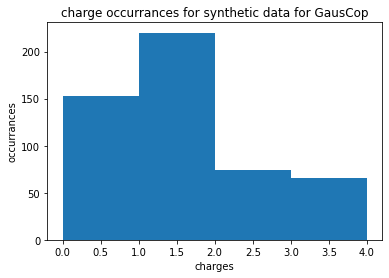

In [27]:
from matplotlib import pyplot as plt
#num_bins = 20
#group = [1000*i for i in range(13,65)]
#plt.hist(synth_data["charges"], group)
total01=len(synth_data["charges"])
ans01=[]
for i in range(4):
    num=len(synth_data["charges"][synth_data["charges"]==i])
    ans01.append(num/total01)
ans01=np.array(ans01)
print("The ratio of the synthetic data of charge >14000 is %.4f"%sum(ans01[14:]))
plt.title("charge occurrances for synthetic data for GausCop")
plt.xlabel("charges")
plt.ylabel("occurrances")
plt.hist(synth_data["charges"],bins=[i for i in range (5)])

The ratio of the original data of charge >14000 is 0.0000


(array([359., 633., 190., 156.]),
 array([0, 1, 2, 3, 4]),
 <a list of 4 Patch objects>)

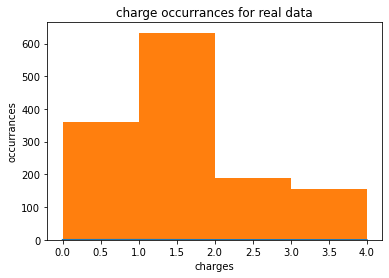

In [28]:
#plt.hist(ins_data["charges"][ins_data["charges"]>13000], group)
total02=len(ins_data["charges"])
ans02 = []
for i in range(5):
    num=len(ins_data["charges"][ins_data["charges"]==i])
    ans02.append(num/total02)
ans02=np.array(ans02)
print("The ratio of the original data of charge >14000 is %.4f"%sum(ans02[14:]))
plt.plot(range(5),ans02)
plt.title("charge occurrances for real data")
plt.xlabel("charges")
plt.ylabel("occurrances")
plt.hist(ins_data["charges"],bins=[i for i in range (5)])

Now this data can be fed into a new `setup` but this time declaring `test_data` as the test data that was created earlier. 

So there is a combination of **synthetic and real data in the training set** but only real in the test data.

In [29]:
# Run pycaret setup w/synthetic data
setup(data = mixed, 
      target = target, 
      test_data = test,
      train_size = 0.7, 
      numeric_features = cont_feats,
      categorical_features = cat_feats,
      ordinal_features = ord_feats,
      normalize_method = "zscore",
      ignore_low_variance = True,
      silent = True, verbose = False)

(25       1.0
 336      1.0
 47       0.0
 106      0.0
 1269     1.0
         ... 
 595      2.0
 596     14.0
 597      2.0
 598      0.0
 599      0.0
 Name: charges, Length: 1402, dtype: float32,
        age        bmi  children  sex_male  smoker_yes  region_northeast  \
 764   45.0  25.174999       2.0       0.0         0.0               1.0   
 887   36.0  30.020000       0.0       0.0         0.0               0.0   
 890   64.0  26.885000       0.0       0.0         1.0               0.0   
 1293  46.0  25.745001       3.0       1.0         0.0               0.0   
 259   19.0  31.920000       0.0       1.0         1.0               0.0   
 ...    ...        ...       ...       ...         ...               ...   
 588   61.0  35.910000       0.0       0.0         0.0               1.0   
 872   42.0  24.860001       0.0       1.0         0.0               0.0   
 914   33.0  24.605000       2.0       1.0         0.0               0.0   
 679   49.0  23.180000       2.0       0

Now setup the `compare_models` can be checked again. Interestingly the `AUC`, `Recall` and `Precision` all went up considerably. `Recall` nearly doubled!

In [30]:
compare_models()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lr,Logistic Regression,0.6503,0.0000,0.1889,0.5862,0.6017,0.4634,0.4766,1.4090
rf,Random Forest Classifier,0.6396,0.0000,0.1775,0.5972,0.6104,0.4687,0.4728,0.1720
ridge,Ridge Classifier,0.6389,0.0000,0.1854,0.5781,0.5834,0.4505,0.4638,0.0190
lda,Linear Discriminant Analysis,0.6247,0.0000,0.1738,0.5087,0.5483,0.4273,0.4461,0.0230
gbc,Gradient Boosting Classifier,0.6211,0.0000,0.1469,0.6137,0.6057,0.4541,0.4585,2.2800
lightgbm,Light Gradient Boosting Machine,0.6190,0.0000,0.1785,0.5751,0.5929,0.4419,0.4449,0.6760
et,Extra Trees Classifier,0.5826,0.0000,0.1558,0.5573,0.5656,0.4016,0.4037,0.1600
ada,Ada Boost Classifier,0.5641,0.0000,0.1248,0.3907,0.4612,0.3125,0.3427,0.0750
knn,K Neighbors Classifier,0.5241,0.0000,0.1227,0.4256,0.4561,0.2723,0.2851,0.3100
dt,Decision Tree Classifier,0.5034,0.0000,0.1315,0.5160,0.5056,0.3190,0.3206,0.0160


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=722, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

A gradient boosting classifier was decided upon.

# **SECOND TRIAL**, NORMALIZED, GAUSSIANCOPULA

With the tuner ready it's as simple as creating a training loop and then calling the tuner within the loop and feeding the hyperparameters into the CopulaGAN.

In [31]:
best_score = 0 # Keep track of best score
# best_params=None
best_data = None
tracker = 0 # Keep track of how many loops have completed
flag = True
scores=[]

real = train # Filter to only those employees that left

import time
ST=time.time()

## TRAINING LOOP START ##
for _ in range(30): # only 1 and do the test

    # Increment the tracker
    tracker += 1
  
    # Every 5 loops output the tracker -> 1 loop
    print(tracker)



    # Record the hyperparameters and score      
    # proposal = tuner.propose(1)
  
    # NOTE - batch_size is multiplied by 10 as needs to be a factor of 10
    #model = GaussianCopula(constraints = [age_constraint, children_constraint, bmi_constraint, charges_constraint])
    model = GaussianCopula(constraints = [age_constraint, children_constraint, bmi_constraint])
    
    # Fit the CopulaGAN
    model.fit(real)
    # Create 600 rows of data
    synth_data = model.sample(num_rows = 4000)
  
    # Evaluate the synthetic data against the real data
    score = evaluate(synthetic_data = synth_data, real_data = real)
    scores.append(score)

    print(score)
    # If the new hyperparameters beat the best ones, store them along with the score
    if score > best_score or flag:
        flag = False
        best_data = synth_data
        best_distributions = model.get_distributions()
        # best_params = proposal
        best_score = score
  
    # Record the hyperparameters and score      
    # tuner.record(proposal, score)


## TRAINING LOOP END ##
ED=time.time()
print("time used: %.3f mins"%((ED-ST)/60))

1
0.5275844036295029
2
0.5181093848455673
3
0.5221526699276803
4
0.5211532717845322
5
0.5137176583926623
6
0.5168156320570793
7
0.5141807818130569
8
0.5184860335471013
9
0.5119382059182979
10
0.5107768469799239
11
0.513990731259105
12
0.5178179261000748
13
0.5197313501014805
14
0.5271443085517642
15
0.5178414269695943
16
0.5150896582153722
17
0.5159124556928929
18
0.5137903355012166
19
0.5164806351291887
20
0.5185757135399602
21
0.519343151181915
22
0.5166777931526979
23
0.514949036686778
24
0.5203452136262587
25
0.5262237653685493
26
0.5191289871486541
27
0.5169025976694559
28
0.5215318960023533
29
0.5156132902222672
30
0.5180889822322882
time used: 8.453 mins


In [32]:
best_data

,age,sex,bmi,children,smoker,region,charges
0,64,male,37.544374,2,no,southeast,10
3,37,male,27.798550,0,no,northeast,1
5,55,male,41.745878,3,no,southeast,0
6,25,female,41.496976,0,no,southeast,0
10,54,male,35.493842,0,no,northeast,1
...,...,...,...,...,...,...,...
2954,44,male,30.827452,1,no,northeast,2
2955,48,male,39.628930,1,no,southeast,2
2956,47,male,32.412486,1,no,southeast,3
2957,23,female,32.979521,2,no,southeast,1


In [33]:
best_distributions

{'age': 'copulas.univariate.beta.BetaUnivariate',
 'bmi': 'copulas.univariate.gamma.GammaUnivariate',
 'children': 'copulas.univariate.student_t.StudentTUnivariate',
 'charges': 'copulas.univariate.log_laplace.LogLaplace',
 'sex#0': 'copulas.univariate.gaussian.GaussianUnivariate',
 'sex#1': 'copulas.univariate.gaussian.GaussianUnivariate',
 'smoker#0': 'copulas.univariate.gamma.GammaUnivariate',
 'smoker#1': 'copulas.univariate.log_laplace.LogLaplace',
 'region#0': 'copulas.univariate.gaussian.GaussianUnivariate',
 'region#1': 'copulas.univariate.log_laplace.LogLaplace',
 'region#2': 'copulas.univariate.gaussian.GaussianUnivariate',
 'region#3': 'copulas.univariate.log_laplace.LogLaplace'}

In [34]:
score = evaluate(synthetic_data = best_data, real_data = real, aggregate = False)
score

,metric,name,raw_score,normalized_score,min_value,max_value,goal
0,BNLogLikelihood,BayesianNetwork Log Likelihood,-2.312205e+00,0.099043,-inf,0.0,MAXIMIZE
1,LogisticDetection,LogisticRegression Detection,2.912722e-01,0.291272,0.0,1.0,MAXIMIZE
2,SVCDetection,SVC Detection,4.102436e-01,0.410244,0.0,1.0,MAXIMIZE
11,GMLogLikelihood,GaussianMixture Log Likelihood,-3.626298e+09,0.000000,-inf,inf,MAXIMIZE
12,CSTest,Chi-Squared,8.389655e-01,0.838966,0.0,1.0,MAXIMIZE
13,KSTest,Inverted Kolmogorov-Smirnov D statistic,8.365865e-01,0.836587,0.0,1.0,MAXIMIZE
14,KSTestExtended,Inverted Kolmogorov-Smirnov D statistic,8.191118e-01,0.819112,0.0,1.0,MAXIMIZE
27,ContinuousKLDivergence,Continuous Kullback–Leibler Divergence,7.306722e-01,0.730672,0.0,1.0,MAXIMIZE
28,DiscreteKLDivergence,Discrete Kullback–Leibler Divergence,7.225031e-01,0.722503,0.0,1.0,MAXIMIZE


(array([ 759., 1136.,  380.,  287.]),
 array([0, 1, 2, 3, 4]),
 <a list of 4 Patch objects>)

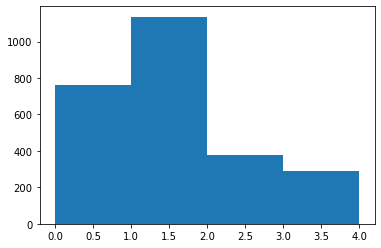

In [35]:
best=best_data
best_data=best_data[~best_data.index.duplicated()]
num_bins = 20
plt.hist(best_data["charges"], [i for i in range (5)])

In [36]:
synth=[]
for i in range (4):
    orig_size=len(train[train["charges"]==i])
    synth_part=best_data[best_data["charges"]==i]
    generate=synth_part.sample(n=min(max(0,350-orig_size),len(synth_part)))
    print(len(generate))
    synth.append(generate)
synth=pd.concat(synth)
synth.sample(frac=1)

139
0
228
177


,age,sex,bmi,children,smoker,region,charges
918,41,female,29.200900,1,no,southeast,2
1700,41,male,31.564449,1,no,southeast,3
826,59,female,28.799381,0,no,northeast,3
1812,30,male,34.365266,1,no,southeast,0
97,63,female,29.016345,0,no,northeast,2
...,...,...,...,...,...,...,...
695,30,male,32.089190,4,no,southeast,3
1340,39,female,37.696916,2,no,southeast,2
1460,31,female,38.872626,3,no,southeast,3
1761,51,male,33.208269,2,no,southeast,0


In [37]:
score = evaluate(synthetic_data = synth, real_data = train, aggregate = True)
score

0.4638304217623009

In [38]:
print('Best score obtained: ', best_score)

Best score obtained:  0.5275844036295029


In [39]:
print(max(scores))
print(min(scores))

0.5275844036295029
0.5107768469799239


In [40]:
model.save('best_copula.pkl')

In [41]:
synth.to_csv("ins_synth_dat_norm_GCImb.csv", index = False)

# **Setting up data for round 2**
The real dataset can be split into 60:40 training/test. Once this has been split the synthetic data can be added to the training data. This in a way doesn't "waste" the real dataset in the training.

In [42]:
# Load synth data in
synth_data2 = pd.read_csv("ins_synth_dat_norm_GCImb.csv")

# Add the 600 synthetic rows of data to training data + remove dataset column
mixed = pd.concat([train, synth_data2])

In [43]:
mixed

,age,sex,bmi,children,smoker,region,charges
25,59,female,27.720000,3,no,southeast,1
336,60,male,25.740000,0,no,southeast,1
47,28,female,34.770000,0,no,northwest,0
106,19,female,28.400000,1,no,southwest,0
1269,45,male,27.500000,3,no,southwest,1
...,...,...,...,...,...,...,...
539,62,female,41.090543,1,no,southwest,3
540,49,female,34.978322,1,no,northeast,3
541,35,male,41.666198,1,no,southeast,3
542,56,female,46.037417,2,no,southeast,3


In [44]:
print("Training size (real):", train.shape)
print("Training size (fake + real):", mixed.shape)
print("Testing size (real:", test.shape)

Training size (real): (802, 7)
Training size (fake + real): (1346, 7)
Testing size (real: (536, 7)


(array([1346.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.]),
 array([    0,  1000,  2000,  3000,  4000,  5000,  6000,  7000,  8000,
         9000, 10000, 11000, 12000, 13000, 14000, 15000, 16000, 17000,
        18000, 19000, 20000, 21000, 22000, 23000, 24000, 25000, 26000,
        27000, 28000, 29000, 30000, 31000, 32000, 33000, 34000, 35000,
        36000, 37000, 38000, 39000, 40000, 41000, 42000, 43000, 44000,
        45000, 46000, 47000, 48000, 49000, 50000, 51000, 52000, 53000,
        54000, 55000, 56000, 57000, 58000, 59000, 60000, 610

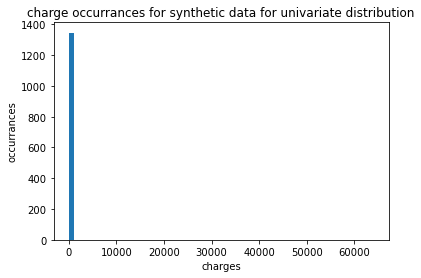

In [45]:
#plt.hist(synth_data["charges"], group)
total=len(mixed["charges"])
plt.title("charge occurrances for synthetic data for univariate distribution")
plt.xlabel("charges")
plt.ylabel("occurrances")
plt.hist(mixed["charges"], [1000*i for i in range (65)])

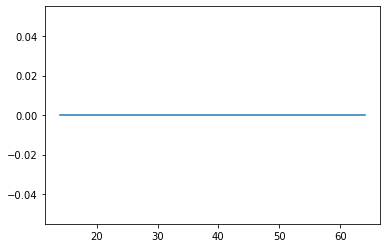

In [46]:
#plt.hist(ins_data["charges"][ins_data["charges"]>13000], group)
total2=len(ins_data["charges"][ins_data["charges"]>13000])
ans2 = []
for i in range(14,65):
    num=len(ins_data["charges"][ins_data["charges"]<(i+1)*1000][ins_data["charges"]>=i*1000])
    ans2.append(num/total)
ans2=np.array(ans2)
plt.plot(range(14,65),ans2)
plt.show()

Now this data can be fed into a new `setup` but this time declaring `test_data` as the test data that was created earlier. 

So there is a combination of **synthetic and real data in the training set** but only real in the test data.

In [47]:
# Run pycaret setup w/synthetic data
setup(data = mixed, 
      target = "charges", 
      test_data = test,
      train_size = 0.7, 
      numeric_features = cont_feats,
      categorical_features = cat_feats,
      ordinal_features = ord_feats,
      normalize_method = "zscore",
      ignore_low_variance = True,
      silent = True, verbose = False)

(25      1
 336     1
 47      0
 106     0
 1269    1
        ..
 539     3
 540     3
 541     3
 542     3
 543     3
 Name: charges, Length: 1346, dtype: int32,
        age        bmi  children  sex_female  smoker_no  region_northeast  \
 764   45.0  25.174999       2.0         1.0        1.0               1.0   
 887   36.0  30.020000       0.0         1.0        1.0               0.0   
 890   64.0  26.885000       0.0         1.0        0.0               0.0   
 1293  46.0  25.745001       3.0         0.0        1.0               0.0   
 259   19.0  31.920000       0.0         0.0        0.0               0.0   
 ...    ...        ...       ...         ...        ...               ...   
 588   61.0  35.910000       0.0         1.0        1.0               1.0   
 872   42.0  24.860001       0.0         0.0        1.0               0.0   
 914   33.0  24.605000       2.0         0.0        1.0               0.0   
 679   49.0  23.180000       2.0         1.0        1.0          

Now setup the `compare_models` can be checked again. Interestingly the `AUC`, `Recall` and `Precision` all went up considerably. `Recall` nearly doubled!

In [48]:
compare_models()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
gbc,Gradient Boosting Classifier,0.6192,0.8225,0.6039,0.6042,0.6029,0.4851,0.4899,0.1840
lightgbm,Light Gradient Boosting Machine,0.5873,0.7928,0.5751,0.5709,0.5725,0.4441,0.4477,0.0960
lr,Logistic Regression,0.5776,0.7986,0.5643,0.5643,0.5622,0.4304,0.4349,0.8010
rf,Random Forest Classifier,0.5776,0.7922,0.5622,0.5608,0.5637,0.4304,0.4333,0.1510
lda,Linear Discriminant Analysis,0.5584,0.7951,0.5462,0.5357,0.5335,0.4045,0.4125,0.0140
et,Extra Trees Classifier,0.5523,0.7741,0.5380,0.5415,0.5412,0.3973,0.4001,0.1460
ridge,Ridge Classifier,0.5487,0.0000,0.5352,0.5090,0.4945,0.3889,0.4068,0.0140
ada,Ada Boost Classifier,0.5399,0.7512,0.5211,0.5204,0.5215,0.3785,0.3830,0.0460
nb,Naive Bayes,0.5391,0.7927,0.5269,0.5176,0.4923,0.3785,0.3955,0.0170
qda,Quadratic Discriminant Analysis,0.5095,0.7526,0.4907,0.5076,0.4787,0.3379,0.3508,0.0160


GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=2103, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

A gradient boosting classifier was decided upon.

# **Finalising the model**
Now with the model trained and evaluated it needs to be **finalised**. This encorporates the test data into the model that will be used on unseen data.

# **SECOND TRIAL**, NORMALIZED, GAUSSIANCOPULA, CATFUZ USED

With the tuner ready it's as simple as creating a training loop and then calling the tuner within the loop and feeding the hyperparameters into the CopulaGAN.

In [50]:
best_score = 0 # Keep track of best score
# best_params=None
best_data = None
tracker = 0 # Keep track of how many loops have completed
flag = True
scores=[]

real = train # Filter to only those employees that left

import time
ST=time.time()

## TRAINING LOOP START ##
for _ in range(30): # only 1 and do the test

    # Increment the tracker
    tracker += 1
  
    # Every 5 loops output the tracker -> 1 loop
    print(tracker)



    # Record the hyperparameters and score      
    # proposal = tuner.propose(1)
  
    # NOTE - batch_size is multiplied by 10 as needs to be a factor of 10
    #model = GaussianCopula(constraints = [age_constraint, children_constraint, bmi_constraint, charges_constraint])
    model = GaussianCopula(constraints = [age_constraint, children_constraint, bmi_constraint],
                          categorical_transformer = "categorical_fuzzy")
    
    # Fit the CopulaGAN
    model.fit(real)
    # Create 600 rows of data
    synth_data = model.sample(num_rows = 1500)
  
    # Evaluate the synthetic data against the real data
    score = evaluate(synthetic_data = synth_data, real_data = real)
    scores.append(score)

    print(score)
    # If the new hyperparameters beat the best ones, store them along with the score
    if score > best_score or flag:
        flag = False
        best_data = synth_data
        best_distributions = model.get_distributions()
        # best_params = proposal
        best_score = score
  
    # Record the hyperparameters and score      
    # tuner.record(proposal, score)


## TRAINING LOOP END ##
ED=time.time()
print("time used: %.3f mins"%((ED-ST)/60))

1
0.593531375158316
2
0.5916562081735116
3
0.620808138483665
4
0.6223958894557854
5
0.6142930982538392
6
0.6068148541572098
7
0.6036043261213889
8
0.6018736496562076
9
0.611498701716493
10
0.5903409738509541
11
0.6197040288655555
12
0.6022031803301383
13
0.6341848756978163
14
0.5969202636110253
15
0.5984269206867766
16
0.6007518934871291
17
0.6043504886123423
18
0.605325262705313
19
0.598703448186977
20
0.6310487158382103
21
0.609915305704626
22
0.6175709320052397
23
0.61557029974653
24
0.6190982780078934
25
0.61351499247325
26
0.6184674430546147
27
0.6164024338111371
28
0.6075588526741691
29
0.6051300354048221
30
0.5986400431217607
time used: 5.345 mins


In [51]:
best_data

,age,sex,bmi,children,smoker,region,charges
1,34,female,40.918110,0,no,southeast,1
2,18,male,33.546034,2,no,southwest,1
7,40,female,27.827115,2,no,northeast,0
9,58,male,21.780807,2,no,northwest,97
13,41,female,27.913623,1,no,northwest,0
...,...,...,...,...,...,...,...
1131,48,female,39.892767,0,no,southwest,1
1133,52,female,41.893354,2,no,southwest,2
3,18,male,37.658512,0,no,southwest,1
4,23,female,33.243142,1,no,southeast,0


In [52]:
best_distributions

{'age': 'copulas.univariate.beta.BetaUnivariate',
 'sex': 'copulas.univariate.truncated_gaussian.TruncatedGaussian',
 'bmi': 'copulas.univariate.gamma.GammaUnivariate',
 'children': 'copulas.univariate.student_t.StudentTUnivariate',
 'smoker': 'copulas.univariate.log_laplace.LogLaplace',
 'region': 'copulas.univariate.beta.BetaUnivariate',
 'charges': 'copulas.univariate.log_laplace.LogLaplace'}

(array([298., 435., 145., 107.]),
 array([0, 1, 2, 3, 4]),
 <a list of 4 Patch objects>)

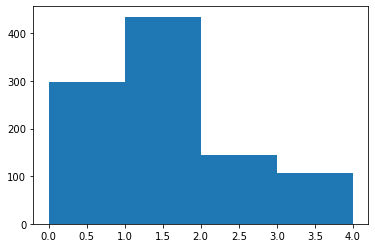

In [53]:
best=best_data
best_data=best_data[~best_data.index.duplicated()]
num_bins = 20
plt.hist(best_data["charges"], [i for i in range (5)])

In [54]:
score = evaluate(synthetic_data = best_data, real_data = real, aggregate = False)
score

,metric,name,raw_score,normalized_score,min_value,max_value,goal
0,BNLogLikelihood,BayesianNetwork Log Likelihood,-2.390062e+00,0.091624,-inf,0.0,MAXIMIZE
1,LogisticDetection,LogisticRegression Detection,5.422671e-01,0.542267,0.0,1.0,MAXIMIZE
2,SVCDetection,SVC Detection,5.796417e-01,0.579642,0.0,1.0,MAXIMIZE
11,GMLogLikelihood,GaussianMixture Log Likelihood,-9.083410e+09,0.000000,-inf,inf,MAXIMIZE
12,CSTest,Chi-Squared,8.972743e-01,0.897274,0.0,1.0,MAXIMIZE
13,KSTest,Inverted Kolmogorov-Smirnov D statistic,8.529786e-01,0.852979,0.0,1.0,MAXIMIZE
14,KSTestExtended,Inverted Kolmogorov-Smirnov D statistic,8.877985e-01,0.887799,0.0,1.0,MAXIMIZE
27,ContinuousKLDivergence,Continuous Kullback–Leibler Divergence,7.239406e-01,0.723941,0.0,1.0,MAXIMIZE
28,DiscreteKLDivergence,Discrete Kullback–Leibler Divergence,9.427360e-01,0.942736,0.0,1.0,MAXIMIZE


In [55]:
synth=[]
for i in range (4):
    orig_size=len(train[train["charges"]==i])
    synth_part=best_data[best_data["charges"]==i]
    generate=synth_part[:140]
    synth.append(generate)
synth=pd.concat(synth)
synth.sample(frac=1)

,age,sex,bmi,children,smoker,region,charges
305,48,male,31.598138,1,no,northeast,2
1402,59,male,42.389118,1,no,northeast,3
559,59,male,37.527132,0,no,southwest,0
1272,51,male,24.087803,1,yes,northeast,3
539,53,female,37.769321,1,no,southeast,1
...,...,...,...,...,...,...,...
272,21,male,40.433699,1,no,northwest,1
196,44,female,34.183052,1,no,northwest,1
51,23,male,39.202968,2,no,northwest,1
627,34,male,31.542049,0,no,northwest,2


In [56]:
score = evaluate(synthetic_data = synth, real_data = train, aggregate = True)
score

0.6190542720618134

In [57]:
print('Best score obtained: ', best_score)

Best score obtained:  0.6341848756978163


In [58]:
print(max(scores))
print(min(scores))

0.6341848756978163
0.5903409738509541


In [59]:
model.save('best_copula.pkl')

In [60]:
synth.to_csv("ins_synth_GC_norm_CF.csv", index = False)
best_data.to_csv("ins_synth_GC_CF.csv", index = False)

# **Setting up data for round 2**
The real dataset can be split into 60:40 training/test. Once this has been split the synthetic data can be added to the training data. This in a way doesn't "waste" the real dataset in the training.

In [78]:
# Load synth data in
synth_data2 = pd.read_csv("ins_synth_GC_norm_CF.csv")

# Add the 600 synthetic rows of data to training data + remove dataset column
mixed = pd.concat([train, synth_data2])

In [79]:
mixed

,age,sex,bmi,children,smoker,region,charges
25,59,female,27.720000,3,no,southeast,1
336,60,male,25.740000,0,no,southeast,1
47,28,female,34.770000,0,no,northwest,0
106,19,female,28.400000,1,no,southwest,0
1269,45,male,27.500000,3,no,southwest,1
...,...,...,...,...,...,...,...
479,47,male,39.736889,2,no,northeast,3
480,60,male,32.241520,0,no,northeast,3
481,60,male,34.384725,1,no,northeast,3
482,41,female,31.689582,1,no,southwest,3


In [80]:
print("Training size (real):", train.shape)
print("Training size (fake + real):", mixed.shape)
print("Testing size (real:", test.shape)

Training size (real): (802, 7)
Training size (fake + real): (1286, 7)
Testing size (real: (536, 7)


Now this data can be fed into a new `setup` but this time declaring `test_data` as the test data that was created earlier. 

So there is a combination of **synthetic and real data in the training set** but only real in the test data.

In [81]:
# Run pycaret setup w/synthetic data
setup(data = mixed, 
      target = "charges", 
      test_data = test,
      train_size = 0.7, 
      numeric_features = cont_feats,
      categorical_features = cat_feats,
      ordinal_features = ord_feats,
      normalize_method = "zscore",
      ignore_low_variance = True,
      silent = True, verbose = False)

(25      1
 336     1
 47      0
 106     0
 1269    1
        ..
 479     3
 480     3
 481     3
 482     3
 483     3
 Name: charges, Length: 1286, dtype: int32,
        age        bmi  children  sex_female  smoker_no  region_northeast  \
 764   45.0  25.174999       2.0         1.0        1.0               1.0   
 887   36.0  30.020000       0.0         1.0        1.0               0.0   
 890   64.0  26.885000       0.0         1.0        0.0               0.0   
 1293  46.0  25.745001       3.0         0.0        1.0               0.0   
 259   19.0  31.920000       0.0         0.0        0.0               0.0   
 ...    ...        ...       ...         ...        ...               ...   
 588   61.0  35.910000       0.0         1.0        1.0               1.0   
 872   42.0  24.860001       0.0         0.0        1.0               0.0   
 914   33.0  24.605000       2.0         0.0        1.0               0.0   
 679   49.0  23.180000       2.0         1.0        1.0          

Now setup the `compare_models` can be checked again. Interestingly the `AUC`, `Recall` and `Precision` all went up considerably. `Recall` nearly doubled!

In [82]:
compare_models()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lr,Logistic Regression,0.6688,0.7836,0.5951,0.6340,0.6302,0.4990,0.5126,0.1480
gbc,Gradient Boosting Classifier,0.6595,0.7802,0.6042,0.6237,0.6285,0.4928,0.5009,0.1640
ridge,Ridge Classifier,0.6549,0.0000,0.5796,0.6220,0.6113,0.4816,0.4965,0.0110
nb,Naive Bayes,0.6424,0.7754,0.5786,0.6163,0.6030,0.4696,0.4818,0.0130
lda,Linear Discriminant Analysis,0.6324,0.7838,0.5616,0.5603,0.5674,0.4496,0.4726,0.0130
rf,Random Forest Classifier,0.6199,0.7634,0.5746,0.5950,0.5984,0.4419,0.4470,0.1530
ada,Ada Boost Classifier,0.6145,0.7221,0.5327,0.5886,0.5727,0.4217,0.4347,0.0410
lightgbm,Light Gradient Boosting Machine,0.6098,0.7636,0.5640,0.5890,0.5932,0.4298,0.4332,0.0880
et,Extra Trees Classifier,0.5679,0.7516,0.5321,0.5572,0.5561,0.3744,0.3770,0.1420
qda,Quadratic Discriminant Analysis,0.5323,0.7251,0.4906,0.5441,0.5128,0.3239,0.3304,0.0140


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=7766, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

A gradient boosting classifier was decided upon.

# **Finalising the model**
Now with the model trained and evaluated it needs to be **finalised**. This encorporates the test data into the model that will be used on unseen data.

In [ ]:
final_gbc = finalize_model(huber)

**NOTE**: I haven't further explored the model e.g. feature importance as the purpose of this project was to focus on synthetic data generation and a streamlit app.

# **Saving and exporting ready for app build**
To use the model in a `streamlit` app certain things need to be exported
* The model
* Preprocessed data
* Preparation steps (`prep pipe`)

In [ ]:
# Model (save)
save_model(final_gbc, "final_gbc")

# Preparation steps (get + save)
prep = get_config("prep_pipe")
joblib.dump(prep, 'prep_pipe.pkl', compress = 1)

# Preprocessed data (get + save)
get_config("X").to_csv("preprocssed_data.csv", index = False)

# **Streamlit app**
The final output of this was a `streamlit` app to allow single predictions w/reason plots or multi predictions from an uploaded csv (see `README.md` and `app.py`).

# **Conclusion**
I think that synthetic data generation can be a powerful tool especially in situations when further data collection cannot be performed in the near term. Fine tuning hyperparameters is great to have but more data and feature engineering are still superior.

In [ ]:
# any random test
import random
# give a data of 20% 0-100, 40% 100-200, 30% 200-300,10% 300-400, 
small=[[100*random.random()] for _ in range (400)]
medium=[[100+100*random.random()] for _ in range (800)]
large=[[200+100*random.random()] for _ in range (600)]
extralarge=[[300+100*random.random()] for _ in range (200)]
mix=small+medium+large+extralarge
random.shuffle(mix)
df = pd.DataFrame(mix, columns=["s"])
final_ans=[]
for _ in range (200):
    toy_ans = list()
    model = GaussianCopula()
    model.fit(df)
    synth = model.sample(num_rows = 2000)
    for i in range(4):
        num=len(synth["s"][synth["s"]<(i+1)*100][synth["s"]>=i*100])
        toy_ans.append(num/2000)
    final_ans.append(toy_ans)
final_ans

In [ ]:
plt.hist(np.array(mix),bins=np.array([10*i for i in range(41)]))

In [ ]:
arr=np.array(final_ans)
trans_arr=np.transpose(arr)
plt.hist(trans_arr[3],bins=np.array([i/500 for i in range (38,55)]))

In [ ]:
plt.hist(trans_arr[2],bins=np.array([i/500 for i in range (140,169)]))

In [ ]:
plt.hist(trans_arr[1],bins=np.array([i/500 for i in range (179,207)]))

In [ ]:
plt.hist(trans_arr[0],bins=np.array([i/500 for i in range (75,99)]))